In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention,Bidirectional
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv("drive/MyDrive/news_summary/news_summary.csv", encoding = "ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112692 entries, 0 to 112691
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   headlines  112692 non-null  object
 1   text       112691 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [ ]:
df.drop_duplicates(subset=['text'],inplace=True)
df.drop_duplicates(subset=['headlines'], keep='first', inplace=True)
df.dropna(axis=0,inplace=True)
input_data = df.loc[:,'text']
target_data = df.loc[:,'headlines']
target_data.replace('', np.nan, inplace=True)

In [ ]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]
contractions=pickle.load(open("drive/MyDrive/contractions.pkl","rb"))['contractions']
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

In [ ]:
def clean(texts,src):
  
  texts = BeautifulSoup(texts, "lxml").text
  words=word_tokenize(texts.lower())
  words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  words= [contractions[w] if w in contractions else w for w in words ]
  words = [re.sub('[^A-Za-z0-9]+', '', x) for x in words]
  if src=="inputs":
    words= [stemm.stem(w) for w in words]
  else:
    words= [w for w in words]
  return words

In [ ]:

for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  
  tr_words= clean("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

In [ ]:
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) 
num_tr_words = len(target_words) 
 
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  49728
number of target words :  33046
maximum input length :  242
maximum target length :  59


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0) 

In [ ]:
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

In [ ]:
import copy
dec_in_data = copy.deepcopy(y_train)
dec_tr_data = copy.deepcopy(y_train)

In [ ]:
for i in range(len(dec_in_data)):
    dec_in_data[i].pop()

for i in range(len(dec_tr_data)):
    dec_tr_data[i] = dec_tr_data[i][1:]

In [ ]:
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_in_data= pad_sequences(dec_in_data,  maxlen=max_tr_len-1, padding='post')
dec_tr_data= pad_sequences(dec_tr_data,  maxlen=max_tr_len-1, padding='post')

In [ ]:
dec_tr_data = dec_tr_data.reshape(len(dec_tr_data),max_tr_len-1,1)

In [ ]:
K.clear_session() 
latent_dim = 500
 
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 

In [ ]:
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
en_states= [state_h3, state_c3]

In [ ]:
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

In [ ]:
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [ ]:
dec_dense = Dense(num_tr_words+1, activation='softmax') 
dec_outputs = dec_dense(merge) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 242)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 242, 500)     24864500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 242, 500),   2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

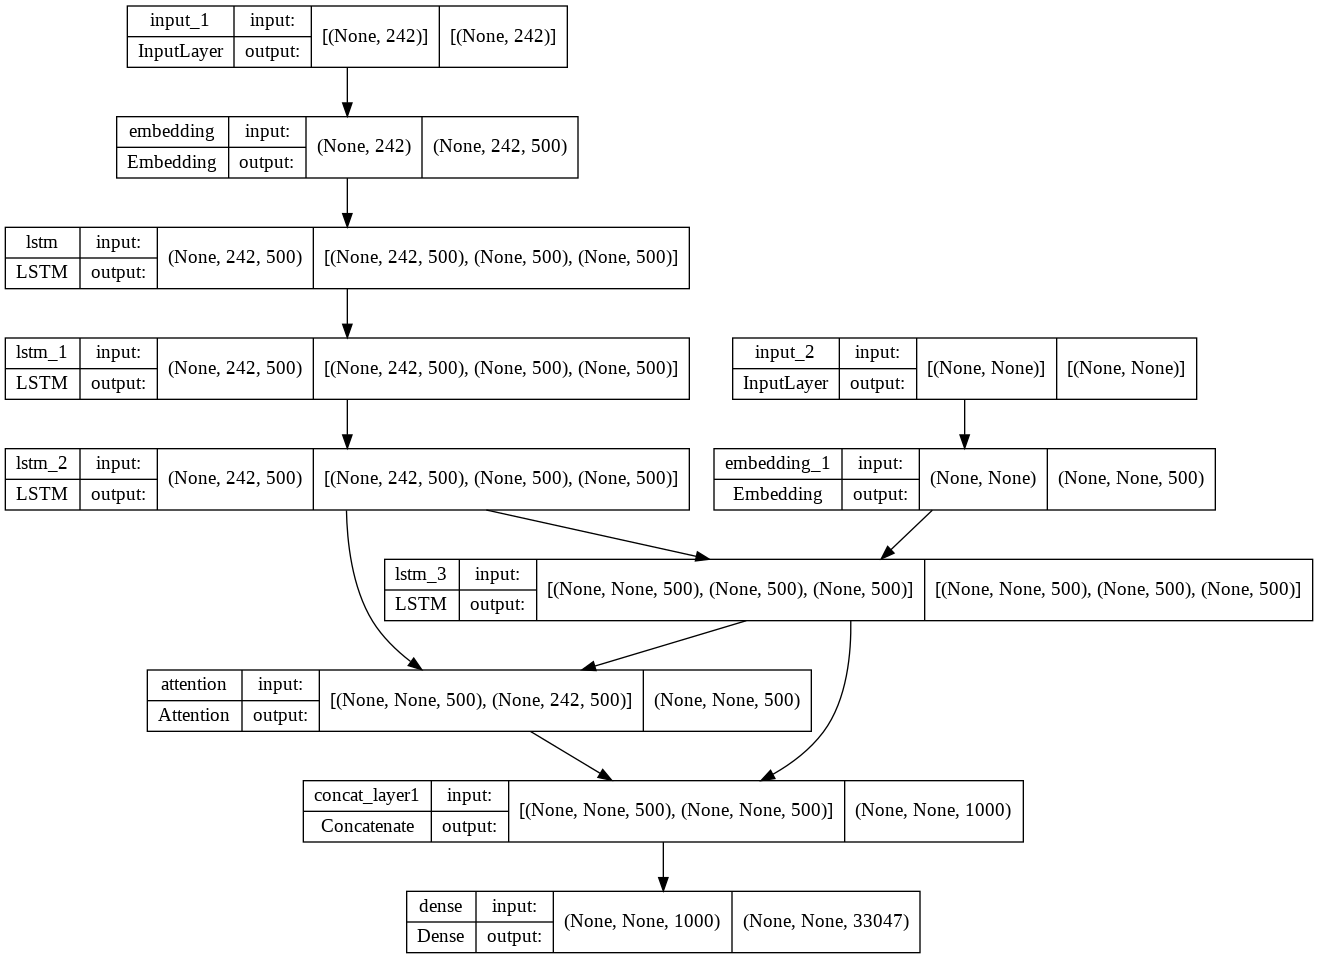

In [ ]:
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
model.fit( 
    [en_in_data, dec_in_data],
    dec_tr_data,  
    epochs=15, 
    validation_split=0.1,
    )
 
#Save model
model.save("drive/MyDrive/news_s2s")

Epoch 1/15
2468/2468 [==============================] - 781s 312ms/step - loss: 1.0798 - accuracy: 0.8748 - val_loss: 1.0099 - val_accuracy: 0.8789
Epoch 2/15
2468/2468 [==============================] - 773s 313ms/step - loss: 0.9638 - accuracy: 0.8822 - val_loss: 0.9545 - val_accuracy: 0.8833
Epoch 3/15
2468/2468 [==============================] - 772s 313ms/step - loss: 0.9097 - accuracy: 0.8865 - val_loss: 0.9285 - val_accuracy: 0.8859
Epoch 4/15
2468/2468 [==============================] - 773s 313ms/step - loss: 0.8711 - accuracy: 0.8899 - val_loss: 0.9004 - val_accuracy: 0.8882
Epoch 5/15
2468/2468 [==============================] - 772s 313ms/step - loss: 0.8422 - accuracy: 0.8928 - val_loss: 0.8900 - val_accuracy: 0.8893
Epoch 6/15
2468/2468 [==============================] - 773s 313ms/step - loss: 0.8194 - accuracy: 0.8957 - val_loss: 0.8899 - val_accuracy: 0.8900
Epoch 7/15
2468/2468 [==============================] - 772s 313ms/step - loss: 0.8016 - accuracy: 0.8980 - val_

INFO:tensorflow:Assets written to: drive/MyDrive/news_s2s/assets


INFO:tensorflow:Assets written to: drive/MyDrive/news_s2s/assets
